# Commitment test version 1

This notebook contains the first version of a commitment test ment to be used in our SRM/Greenland decision problem. The idea of the commitment test is to evolve a state along some plausible scenarios for the next 10000 years. 

How many of those scenarios lead to a GIS without ice or with a small fraction of ice for our present state? This is a quantity that can be computed/known since the beggining. 

How many of those scenarios lead to a GIS without ice or with a small fraction of ice for the state obtained after making some decisions on our decicision problem?

We could ran the test at the end of the decision period (roughly 100 years). If we decided to reward or penalise decisions trajectories that lead to a future with less options for Greenland.

Here we will just create the function that tells us for a given initial state, how many of all the scenarios lead to a GOOD/BAD state. The quantity that controls the definition of GOOD/BAD is called badIceVolume and it is currently set to 0.8 corresponds to 1.4m of sea level rise. 0 ice vol corresponds roughly to 7m.

## Models

We will rely on the BEAM+Aerosols model for the carbon cycle and mean temperature evolution. For the ice sheet evolution we will rely on a fitted double fold model.

## Scenarios for the following 5000 years

The first 2 scenarios are the most popular in IPCC related commitment discussions:

1. **Zero emissions:** No intervention as of tomorrow. 0 carbon emissions, 0 aerosol injections.
2. **Constant emissions** assumes constant emission/injection rates for the future.

NOTE: there is also one more popular scenario: constant concentratio or constant forcing scenario. Although it it quite simple to model, it it complicated to make it fit with our fuctions because we have to give CO2 and aerosol rates instead of radiative forcing. Since it is a bit of an artificial scenario we won't include it.

Other scenarios that make sense to consider given our problem:

3. **Linear decarbonisarion in 50 years** from state's value to 0 emissions and 0 aerosol injections.
4. **Linear decarbonisarion in 200 years** from state's value to 0 emissions and 0 aerosol injections.

5. **Linear decarbonisarion in 50 years to carbon sequestration level low** Constant carbon sequestration at a rate of 0.5 Gton C/yr until pre-industrial atmosphere CO2 concentration is reached.
6. **Linear decarbonisarion in 50 years to carbon sequestration level medium** Constant carbon sequestration at a rate of 2 Gton C/yr until pre-industrial atmosphere CO2 concentration is reached.
7. **Linear decarbonisarion in 50 years to carbon sequestration level high** Constant carbon sequestration at a rate of 4 Gton C/yr until pre-industrial atmosphere CO2 concentration is reached.
8. **Linear decarbonisarion in 200 years to carbon sequestration level low** Constant carbon sequestration at a rate of 0.5 Gton C/yr until pre-industrial atmosphere CO2 concentration is reached.
9. **Linear decarbonisarion in 200 years to carbon sequestration level medium** Constant carbon sequestration at a rate of 2 Gton C/yr until pre-industrial atmosphere CO2 concentration is reached.
10. **Linear decarbonisarion in 200 years to carbon sequestration level high** Constant carbon sequestration at a rate of 4 Gton C/yr until pre-industrial atmosphere CO2 concentration is reached.

11. **Linear decarbonisarion in 50 years and medium injections for 200yrs** 40 MtS/yr aerosol injections.
12. **Linear decarbonisarion in 50 years and high injections for 200yrs** 80 MtS/yr aerosol injections.
13. **Linear decarbonisarion in 200 years and medium injections for 200yrs** 40 MtS/yr aerosol injections.
14. **Linear decarbonisarion in 200 years and high injections for 200yrs** 80 MtS/yr aerosol injections.

These last ones are quite unlikely, not sure we should include them.

15. **sudden Carbon sequestration level low**. Constant carbon sequestration at a rate of 0.5 Gton C/yr until pre-industrial atmosphere CO2 concentration is reached. Then 0 emissions. 0 aerosol injections during the whole time. 
16. **sudden Carbon sequestration level medium**. Constant carbon sequestration at a rate of 2 Gton C/yr until pre-industrial atmosphere CO2 concentration is reached. Then 0 emissions. 0 aerosol injections during the whole time.
17. **sudden Carbon sequestration level high**. Constant carbon sequestration at a rate of 4 Gton C/yr until pre-industrial atmosphere CO2 concentration is reached. Then 0 emissions. 0 aerosol injections during the whole time.
18. **sudden Zero emission & medium injections forever** 0 carbon emission and medium (40 MtS/yr) aerosol injections.
19. **sudden Zero emission & high injections forever** 0 carbon emission and high (80 MtS/yr) aerosol injections.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
#-----------------------------------------------------
# Code and parameters for the dynamics
#-----------------------------------------------------
#-----------------------------------------------------
# fixed BEAM+Aerosol parameters
#-----------------------------------------------------
ka = 0.2              # 1/years
kd = 0.05             # 1/years
delta = 50            # dimensionless
kH = 1.23E3           # dimensionless
k1 = 8.00E-7          # mol/Kg
k2 = 4.53E-10         # mol/Kg
AM = 1.77E20          # mol
OM = 7.8E22           # mol
Alk = 767.0           # Gt C
GtCtoppm = 0.47       # ppm in atmosphere/ Gt C in atmosphere
Mat2000 = 809         # Gt C
Mup2000 = 725         # Gt C 
Mlo2000 = 35642       # Gt C
# parameters entering temperature computation
# carbon parameters
alpha = 3.8         # Watts / m^2
gamma = 0.3         # Watts / (m^2 * Celcius)
Lambda = 1.3        # Watts / (m^2 * Celcius)
muat = 0.022        # 1/years
mulo = 1/60         # 1/years
MatPreInd = 596     # Gt C
# aerosol parameters (taken from Helwegen2019)
eta = 0.742         # dimensionless
alphaSO2 = 65       # Watts / m^2
betaSO2 = 2246      # Mt of S / year
gammaSO2 = 0.23     # dimensionless
#-----------------------------------------------------
# Euler integrator for carbon cycle eqs
#-----------------------------------------------------
def stepC(t, Mat, Mup, Mlo, CO2_emission_rate):
    dt = 0.05
    # requirements: 0 < dt <= 0.05, Mat > 0, Mup > 0, Mlo > 0, -5 Gt C / year <= CO2_emission_rate <= 50 Gt C / year
    if (Mat > 0 and Mup > 0 and Mlo > 0 and -5 <= CO2_emission_rate <= 50 and 0 < dt <= 0.05):
        flowATtoUP = ka*(Mat - (AM*kH*(1 + delta)
                                 *( - Alk*k1 + 4*Alk*k2 + k1*Mup - 8*k2*Mup 
                   + np.sqrt(k1*(Alk**2 *(k1 - 4*k2) - 2*Alk*(k1 - 4*k2)*Mup + k1*Mup**2))
                                  ))/(2*(k1 - 4*k2)*OM))
        flowUPtoLO = kd*(-(Mlo/delta) + Mup)
        dMat = CO2_emission_rate - flowATtoUP
        dMup = - flowUPtoLO + flowATtoUP
        dMlo = flowUPtoLO
        return t+dt, Mat + dMat*dt, Mup + dMup*dt, Mlo + dMlo*dt
    else: print("ERROR: failure to meet requirements in stepC fuction.")
#-----------------------------------------------------        
# Euler integrator for temperature eqs
#-----------------------------------------------------
def stepT(t, Mat, Tat, Tlo, AerosolInjectionRate):
    dt = 1
    # requirements: Mat> 0,  <= AerosolInjectionRate < 100 Mt S / year
    if (Mat > 0 and 0 <= AerosolInjectionRate < 100):
        if AerosolInjectionRate == 0:
            Teq = (1/ Lambda)*( alpha* np.log2(Mat/MatPreInd) )
        elif AerosolInjectionRate > 0:
            Teq = (1/ Lambda)*( alpha* np.log2(Mat/MatPreInd) - 
                  eta*alphaSO2*np.exp( -np.power(betaSO2/AerosolInjectionRate,gammaSO2) ) )
        flowATtoLO = gamma*(Tat - Tlo)
        dTat = muat*( Lambda*(Teq - Tat) - flowATtoLO)
        dTlo = mulo*flowATtoLO
        return Tat + dTat*dt, Tlo + dTlo*dt
    else: print("ERROR: failure to meet requirements in stepT fuction.")
#-----------------------------------------------------        
# Function to fix tipping points on double fold greenland ice sheet model
#-----------------------------------------------------
def fixDFsteady(Tp,Tm,Vp,Vm):
    global eqrhsICE
    if Tp < Tm or Vp < Vm:
        print('PHYSICAL ERROR: check that Tp > Tm and Vp > Vm\n');
    # set coeffs
    a = 3*(Vp + Vm)/2
    b = - 3*Vp*Vm
    def c(T):
        return ( Tp*Vm**2*(3*Vp-Vm) - Tm*Vp**2*(3*Vm-Vp) + T*(Vm - Vp)**3 ) / (2*(Tp-Tm))
    def eqrhsICE(V,T):
        return - V**3 + a*V**2 + b*V + c(T)
    #computing steady states
    Tflist = np.linspace(0,1.2*Tp,200)
    steadystates = []
    root1 = []
    root2 = []
    root3 = []
    if abs(np.roots([-1,a,b,c(0)])[0] - 1) > 0.05:
        print('ALARM: Check parameter values, the value of roots at Tf = 0 are ', np.roots([-1,a,b,c(0)]))
    else: print('Value of roots at Tf = 0 are ', np.roots([-1,a,b,c(0)]))
    for Tf in Tflist:
        allroots = np.roots([-1,a,b,c(Tf)])
        steadystates.append(allroots)
        if np.imag(allroots[0]) == 0:
            root1.append([Tf,allroots[0]])
        if np.imag(allroots[1]) == 0:
            root2.append([Tf,allroots[1]])
        if np.imag(allroots[2]) == 0:
            root3.append([Tf,max(0,allroots[2])])
    steadystates = np.array(steadystates)
    root1 = np.array(root1)
    root2 = np.array(root2)
    root3 = np.array(root3)
    #plotting steady states
    plt.plot(root1[:,0],root1[:,1])
    plt.plot(root2[:,0],root2[:,1])
    plt.plot(root3[:,0],root3[:,1])
    plt.plot(Tp,Vp,'o')
    plt.plot(Tm,Vm,'o')
    plt.title('Steady states')
    plt.xlabel('Local temperature anomaly (Celcius)')
    plt.ylabel('Volume fraction')
    plt.grid()
    plt.show()
#-----------------------------------------------------        
# ICE dynamics parameters (these two parameters might need to be tunned if we modify too much the steady states)
#-----------------------------------------------------        
tau_melt = 320 # years
tau_freeze = 1500 # years
#-----------------------------------------------------        
# stepICE : current_volume -> forcing_temperature (at t) -> next_volume
#-----------------------------------------------------        
def stepICE(volume, forcing_temperature, Dt):
    dt = Dt
    if Dt >  50:
        print("Careful, numerical instability might appear in ice sheet evolution. To fix it decrease Dt to smaller than 50.")
    if eqrhsICE(volume, forcing_temperature) > 0:
        next_volume = volume + dt*(1/tau_freeze)*eqrhsICE(volume, forcing_temperature)
    else:
        if volume <= 1e-4:
            next_volume = volume
        else: 
            next_volume = max(0,volume + dt*(1/tau_melt)*eqrhsICE(volume, forcing_temperature))
    return next_volume
#-----------------------------------------------------        
# stepCommitment: x:Xt -> list of good/bad scenarios
# recall:   climate_state = x[1]
#           current_CO2_emission_rate = x[2]
#           current_aerosol_injection_rate = x[3]
#-----------------------------------------------------    
def CommitmentTest(state, plots = 'no'):
    Dt = 4000 #years
    badIceVolume = 0.8 # corresponds to 1.4m of sea level rise. 0 ice vol corresponds roughly to 7m.
    scenarioResults = 2*np.ones(len(scenarios)) # 2s should be changed to 0s if good and to 1s if bad
    iScenario = 0
    for scenario in scenarios:
        CO2_emission_rate, aerosol_injection_rate = fixScenario(scenario, state)
        climate_state = state[1]
        t, Mat, Mup, Mlo, Tat, Tlo, volume = state[1] # extract initial conditions for the step from current state
        t0 = t
        i = 0
        t_list = [t0]
        volume_list = [volume]
        temp_list = [Tat]
        CO2_list = [CO2_emission_rate(t0)]
        aerosol_list = [aerosol_injection_rate(t0)]
        # BEAM step loop (step size 0.05 yr)
        while t < t0+Dt-0.05:
            # stops carbon seq if atmosphere C02 reaches pre industrial levels.
            if Mat <= MatPreInd: 
                def CO2_emission_rate(t):
                    return 0
            t, Mat, Mup, Mlo = stepC(t, Mat, Mup, Mlo, CO2_emission_rate(t))
            i += 1
            # temperature step (step size 1 yr)
            if i%20 == 0:
                Tat, Tlo = stepT(t, Mat, Tat, Tlo, aerosol_injection_rate(t))     
            # ice step (step size 5 yrs)
            if i%100 == 0: 
                Tforcing_ICE = 1.33*Tat
                volume = stepICE(volume, Tforcing_ICE, 10)
                # add quantities to list for plotting:
                if plots == 'yes':
                    t_list.append(t)
                    volume_list.append(volume)
                    temp_list.append(Tat)
                    CO2_list.append(CO2_emission_rate(t))
                    aerosol_list.append(aerosol_injection_rate(t))
                # check if vol is smaller than badIceVolume at any time in the evolution and stop evolution
                if volume <= badIceVolume:
                    break
        if volume <= badIceVolume:
                    scenarioResults[iScenario] = 1
        else: scenarioResults[iScenario] = 0
        #-----------------------------------------------------
        # plots = 'yes'
        #-----------------------------------------------------
        if plots == 'yes':    
            plt.figure()
            # upper subplot with emission and injection scenario
            ax1 = plt.subplot(211)
            ax1.set_title('Scenario: '+ scenario)
            color = 'tab:blue'
            ax1.set_xlabel('year')
            pl1 = ax1.plot(t_list, CO2_list, color = color, label = 'CO2 rate')
            ax1.tick_params(axis='y')
            ax1.legend(loc = 'upper left')
            plt.grid()
            ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
            color = 'tab:red'
            pl2 = ax2.plot(t_list, aerosol_list, color = color, label = 'aerosol rate')
            ax2.tick_params(axis='y')
            ax2.legend(loc = 'upper right')
            # lower subplot with Tat and ice volume
            ax3 = plt.subplot(212)
            color = 'tab:blue'
            ax3.set_xlabel('year')
            pl3 = ax3.plot(t_list, volume_list, color = color, label = 'ice volume')
            ax3.tick_params(axis='y')
            ax3.legend(loc = 'upper left')
            plt.grid()
            ax4 = ax3.twinx()  # instantiate a second axes that shares the same x-axis
            color = 'tab:red'
            pl4 = ax4.plot(t_list, temp_list, color = color, label = 'temperature')
            ax4.tick_params(axis='y')
            ax4.legend(loc = 'upper right')

            plt.show()

        iScenario += 1
    return scenarioResults

In [3]:
#-----------------------------------------------------------
# Defining scenarios. 
#
# fixScenario: scenario -> state -> (time -> CO2_emission_rate, time -> aerosol_injection_rate)
#
# recall:   climate_state = x[1]
#           current_CO2_emission_rate = x[2]
#           current_aerosol_injection_rate = x[3]
#-----------------------------------------------------------

scenarios = ['ZeroEmissions', 'ConstantEmissionsInj','LinDec50','LinDec200',
             'LinDec50+SeqLow','LinDec50+SeqMed','LinDec50+SeqHigh', 
             'LinDec200+SeqLow','LinDec200+SeqMed','LinDec200+SeqHigh',
             'LinDec50+InjMed200','LinDec50+InjHigh200', 'LinDec200+InjMed200','LinDec200+InjHigh200',
             'SeqLow', 'SeqMed', 'SeqHigh', 'ZeroEmissions+InjMed', 'ZeroEmissions+InjHigh']


def fixScenario(scenario, state):
    climate_state = state[1]
    t0 = climate_state[0]
    current_CO2_emission_rate = state[2]
    current_aerosol_injection_rate = state[3]
    #-----------------------------------------------------------
    seq_low_rate = 0.5   # GtC/yr
    seq_med_rate = 2     # GtC/yr
    seq_high_rate = 4    # GtC/yr
    inj_med = 40         # MtS/yr
    inj_high = 80        # MtS/yr
    #-----------------------------------------------------------
    if scenario == 'ZeroEmissions':
        def CO2_emission_rate(t):
            return 0 
        def aerosol_injection_rate(t): 
            return 0
    #-----------------------------------------------------------
    elif scenario == 'ConstantEmissionsInj':
        def CO2_emission_rate(t): 
            return current_CO2_emission_rate
        def aerosol_injection_rate(t):
            return current_aerosol_injection_rate
    #-----------------------------------------------------------
    elif scenario == 'LinDec50':
        def CO2_emission_rate(t):
            if t > (t0 + 50):
                return 0
            if t <= (t0 + 50):
                return -(t - t0)*current_CO2_emission_rate/50 + current_CO2_emission_rate
        def aerosol_injection_rate(t): 
            return 0
    #-----------------------------------------------------------
    elif scenario == 'LinDec200':
        def CO2_emission_rate(t):
            if t > (t0 + 200):
                return 0
            if t <= (t0 + 200):
                return -(t - t0)*current_CO2_emission_rate/200 + current_CO2_emission_rate
        def aerosol_injection_rate(t): 
            return 0
    #-----------------------------------------------------------
    elif scenario == 'LinDec50+SeqLow':
        def CO2_emission_rate(t):
            if t > (t0 + 50):
                return -seq_low_rate
            if t <= (t0 + 50):
                return -(t - t0)*(seq_low_rate + current_CO2_emission_rate)/50 + current_CO2_emission_rate
        def aerosol_injection_rate(t): 
            return 0
    #-----------------------------------------------------------
    elif scenario == 'LinDec200+SeqLow':
        def CO2_emission_rate(t):
            if t > (t0 + 200):
                return -seq_low_rate
            if t <= (t0 + 200):
                return -(t - t0)*(seq_low_rate + current_CO2_emission_rate)/200 + current_CO2_emission_rate
        def aerosol_injection_rate(t): 
            return 0
    #-----------------------------------------------------------
    elif scenario == 'LinDec50+SeqMed':
        def CO2_emission_rate(t):
            if t > (t0 + 50):
                return -seq_med_rate
            if t <= (t0 + 50):
                return -(t - t0)*(seq_med_rate + current_CO2_emission_rate)/50 + current_CO2_emission_rate
        def aerosol_injection_rate(t): 
            return 0
    #-----------------------------------------------------------
    elif scenario == 'LinDec200+SeqMed':
        def CO2_emission_rate(t):
            if t > (t0 + 200):
                return -seq_med_rate
            if t <= (t0 + 200):
                return -(t - t0)*(seq_med_rate + current_CO2_emission_rate)/200 + current_CO2_emission_rate
        def aerosol_injection_rate(t): 
            return 0
    #-----------------------------------------------------------
    elif scenario == 'LinDec50+SeqHigh':
        def CO2_emission_rate(t):
            if t > (t0 + 50):
                return -seq_high_rate
            if t <= (t0 + 50):
                return -(t - t0)*(seq_high_rate + current_CO2_emission_rate)/50 + current_CO2_emission_rate
        def aerosol_injection_rate(t): 
            return 0
    #-----------------------------------------------------------
    elif scenario == 'LinDec200+SeqHigh':
        def CO2_emission_rate(t):
            if t > (t0 + 200):
                return -seq_high_rate
            if t <= (t0 + 200):
                return -(t - t0)*(seq_high_rate + current_CO2_emission_rate)/200 + current_CO2_emission_rate
        def aerosol_injection_rate(t): 
            return 0
    #-----------------------------------------------------------
    elif scenario == 'LinDec50+InjMed200':
        def CO2_emission_rate(t):
            if t > (t0 + 50):
                return 0
            if t <= (t0 + 50):
                return -(t - t0)*current_CO2_emission_rate/50 + current_CO2_emission_rate
        def aerosol_injection_rate(t):
            if t > (t0 + 200):
                return 0
            elif t <= (t0 + 200):
                return inj_med
    #-----------------------------------------------------------
    elif scenario == 'LinDec200+InjMed200':
        def CO2_emission_rate(t):
            if t > (t0 + 200):
                return 0
            if t <= (t0 + 200):
                return -(t - t0)*current_CO2_emission_rate/200 + current_CO2_emission_rate
        def aerosol_injection_rate(t): 
            if t > (t0 + 200):
                return 0
            elif t <= (t0 + 200):
                return inj_med
    #-----------------------------------------------------------
    elif scenario == 'LinDec50+InjHigh200':
        def CO2_emission_rate(t):
            if t > (t0 + 50):
                return 0
            if t <= (t0 + 50):
                return -(t - t0)*current_CO2_emission_rate/50 + current_CO2_emission_rate
        def aerosol_injection_rate(t): 
            if t > (t0 + 200):
                return 0
            elif t <= (t0 + 200):
                return inj_high
    #-----------------------------------------------------------
    elif scenario == 'LinDec200+InjHigh200':
        def CO2_emission_rate(t):
            if t > (t0 + 200):
                return 0
            if t <= (t0 + 200):
                return -(t - t0)*current_CO2_emission_rate/200 + current_CO2_emission_rate
        def aerosol_injection_rate(t):
            if t > (t0 + 200):
                return 0
            elif t <= (t0 + 200):
                return inj_high
    #-----------------------------------------------------------
    elif scenario == 'SeqLow':
        def CO2_emission_rate(t):
            return -seq_low_rate
        def aerosol_injection_rate(t):
            return 0
    #-----------------------------------------------------------
    elif scenario == 'SeqMed':
        def CO2_emission_rate(t):
            return -seq_med_rate
        def aerosol_injection_rate(t):
            return 0
    #-----------------------------------------------------------
    elif scenario == 'SeqHigh':
        def CO2_emission_rate(t):
            return -seq_high_rate
        def aerosol_injection_rate(t):
            return 0
    #-----------------------------------------------------------
    elif scenario == 'ZeroEmissions+InjMed':
        def CO2_emission_rate(t):
            return 0
        def aerosol_injection_rate(t):
            return inj_med
    #-----------------------------------------------------------
    elif scenario == 'ZeroEmissions+InjHigh':
        def CO2_emission_rate(t):
            return 0
        def aerosol_injection_rate(t):
            return inj_high
    return [CO2_emission_rate, aerosol_injection_rate] 

In [4]:
scenarios = ['ZeroEmissions', 'ConstantEmissionsInj','LinDec50','LinDec200']
scenarios = ['ZeroEmissions']

Value of roots at Tf = 0 are  [ 0.99054622+0.j          0.19472689+0.09115628j  0.19472689-0.09115628j]


/usr/lib/python3/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


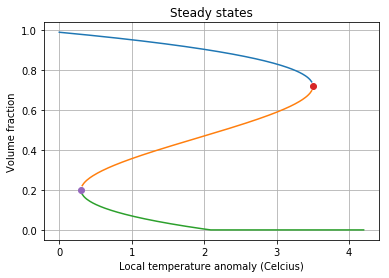

In [5]:
# fixing steady states of double fold system: Tp,Tm,Vp,Vm
fixDFsteady(3.5,0.3,0.72,0.2)

In [30]:
# 0 = good, 1 = bad
# State = (t:int, climate_state, current_CO2_emission_rate, current_aerosol_injection_rate, current_CO2_emission_rate_change )
# climate_state = [time, Mat, Mup, Mlo, Tat, Tlo, volume]
teststate = (1, [2000, Mat2000, Mup2000, Mlo2000, 0.7, 0.2, 1], 8, 0, 0)
scenarios = ['ZeroEmissions', 'ConstantEmissionsInj','LinDec50','LinDec200',
             'LinDec50+SeqLow','LinDec50+SeqMed','LinDec50+SeqHigh', 
             'LinDec200+SeqLow','LinDec200+SeqMed','LinDec200+SeqHigh',
             'LinDec50+InjMed200','LinDec50+InjHigh200', 'LinDec200+InjMed200','LinDec200+InjHigh200',
             'SeqLow', 'SeqMed', 'SeqHigh', 'ZeroEmissions+InjMed', 'ZeroEmissions+InjHigh']
CommitmentTest(teststate, plots = 'no')

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

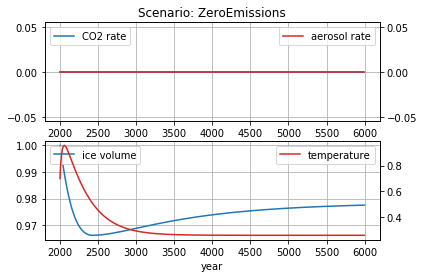

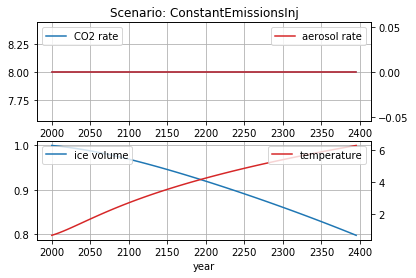

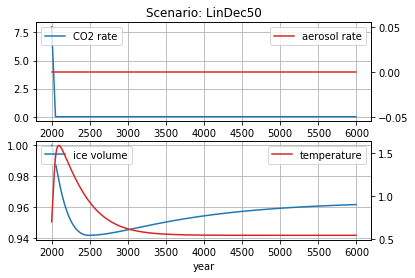

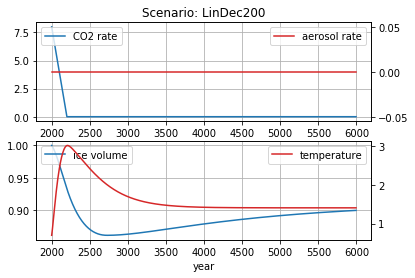

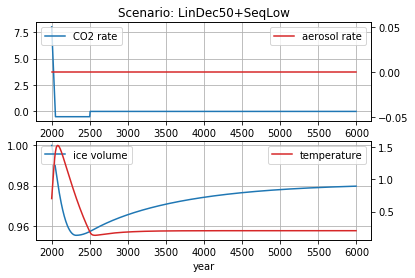

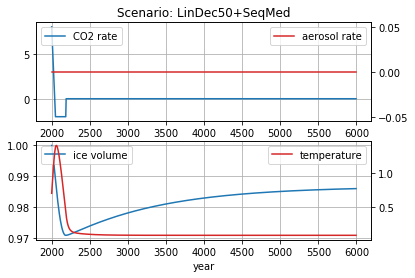

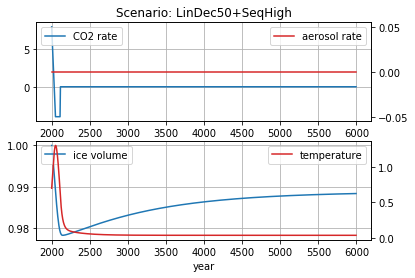

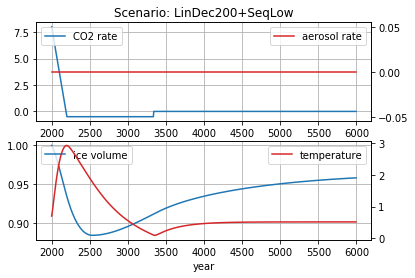

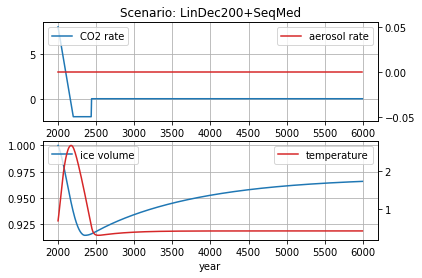

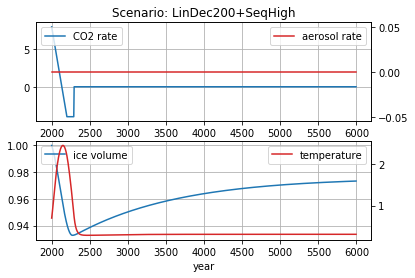

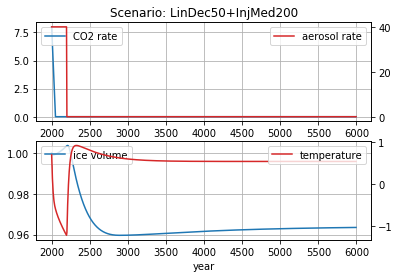

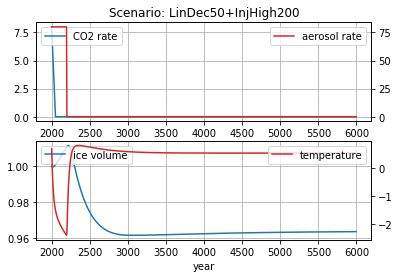

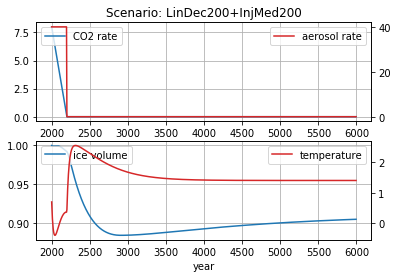

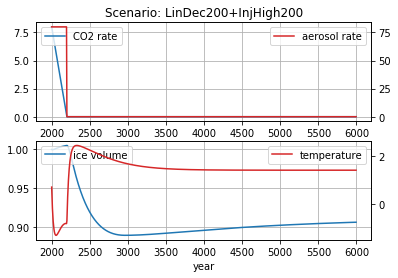

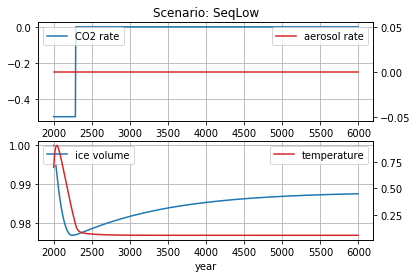

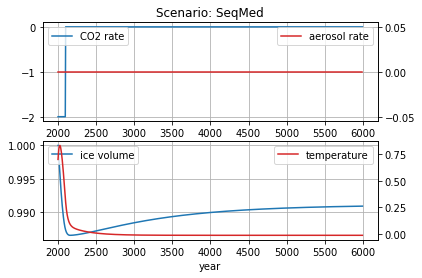

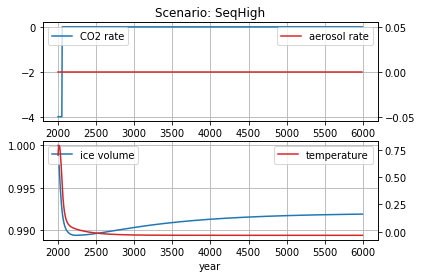

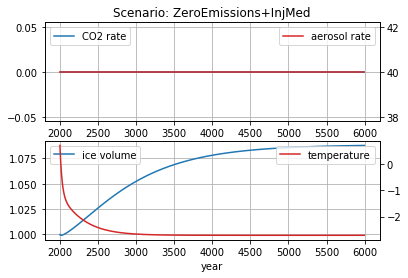

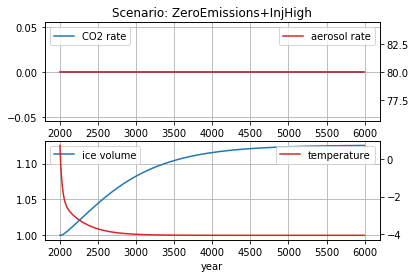

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.])

In [31]:
CommitmentTest(teststate, plots = 'yes')